# Importing libraries for exploratory data analysis, and the dataset for red wines

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.max_columns', 24)
df = pd.read_csv('datasets/wine_quality_red.csv')
df['quality_label']=df['quality'].apply(lambda x: 'low' if x<=5 else 'medium' if x<=7 else 'high')

In [2]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality quality_label  
0      9.4        5           low  
1      9.8        5           low  
2      9.8        5           low  
3      9.8        6        medium  
4      9.4        5           low

# selecting continuos features for predictions

In [3]:
attributes = df.columns[:-2]


In [4]:
df.quality_label.value_counts()

medium    837
low       744
high       18
Name: quality_label, dtype: int64

# running tukey highest significance difference on features to locate statistically significant features of wine, and ploting the results
* p values and alpha are inversed, therefore, pairs in which features with $p^{-1}$ values greater than 20$(0.05^{-1})$ are statistically significant within a confindence level 0f 95%

In [5]:
tukey_results = {}
for attribute in attributes:
    tukey_results[attribute]=pairwise_tukeyhsd(df[attribute],df['quality_label'],0.05)

In [6]:
tukey_df = pd.DataFrame(columns = ['pair','meandiff', 'inv_p_val','feature'])
for key,val in tukey_results.items():
    data = {'pair':['low-high', 'medium-high', 'medium-low'],
        'meandiff':val.meandiffs,
        'inv_p_val':val.pvalues**(-1),
        'feature':[key,key,key]}
    local_data = pd.DataFrame.from_dict(data)
    # display(tukey_df)
    tukey_df = tukey_df.append(local_data, ignore_index = True)

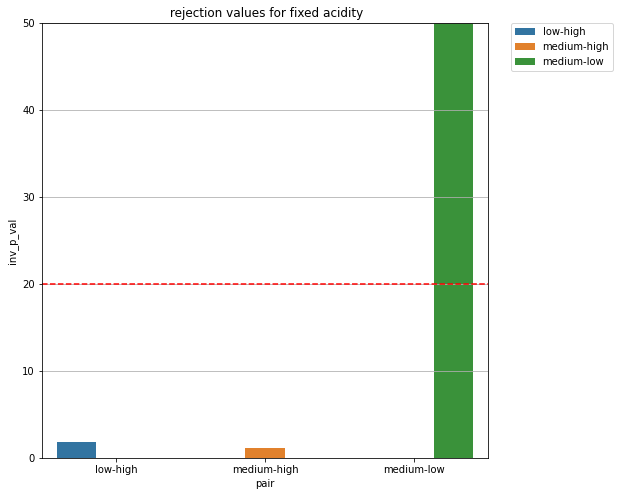

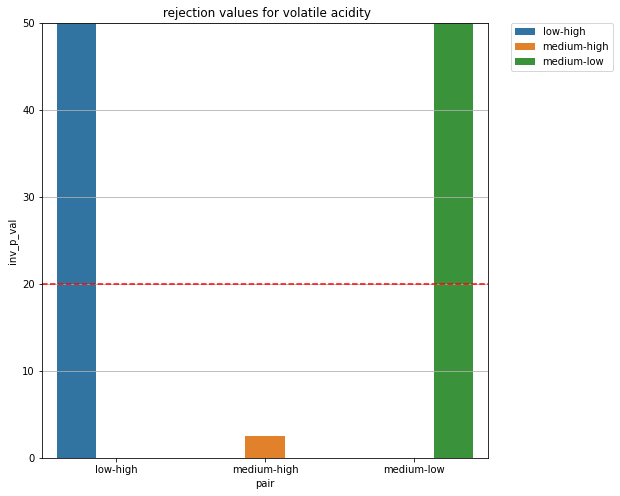

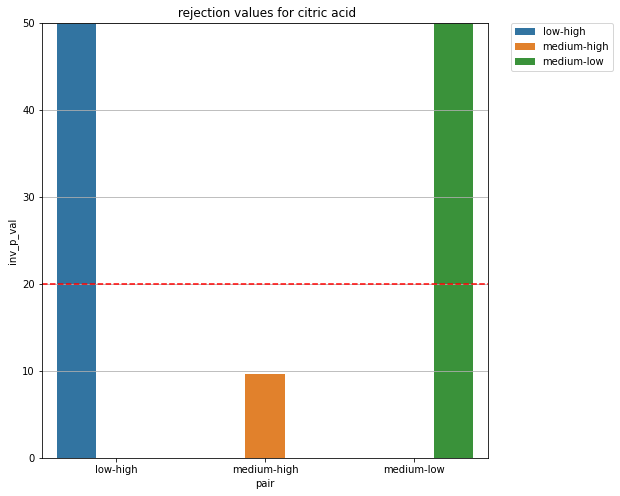

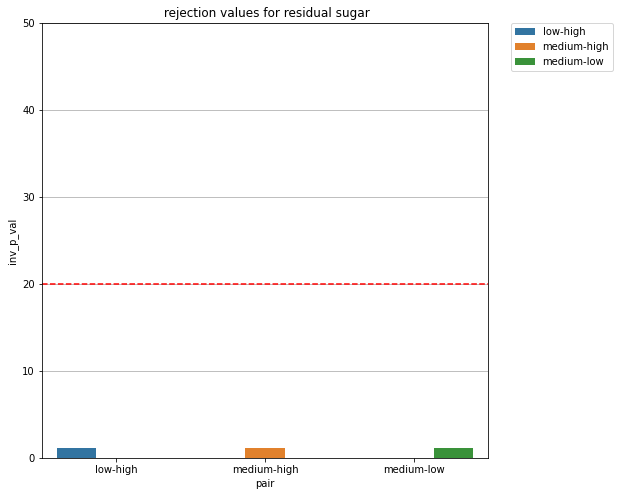

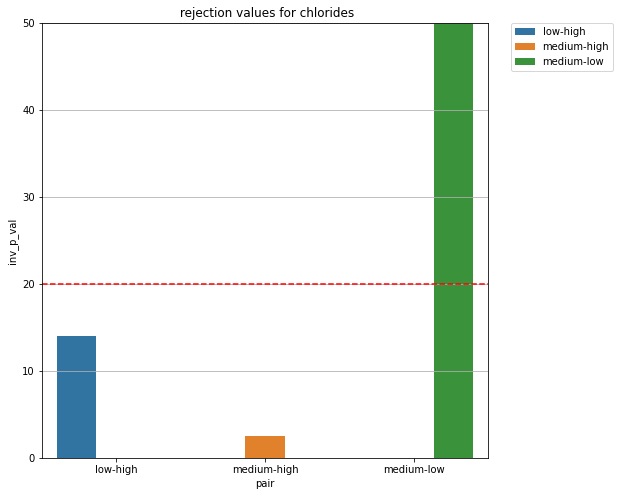

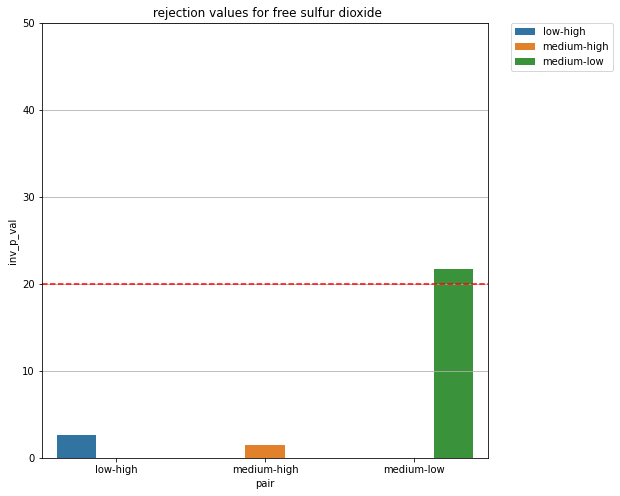

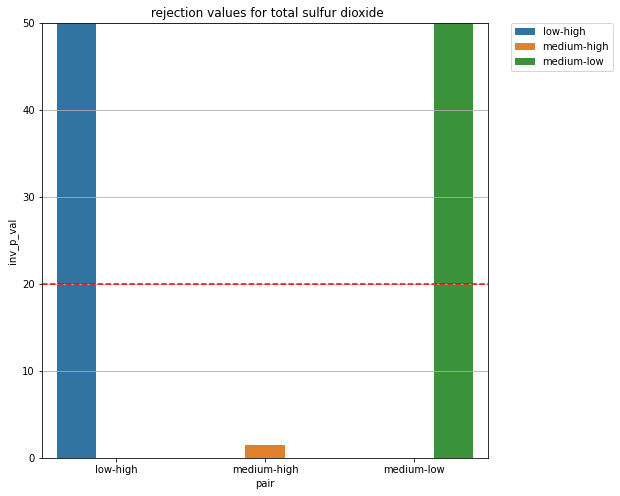

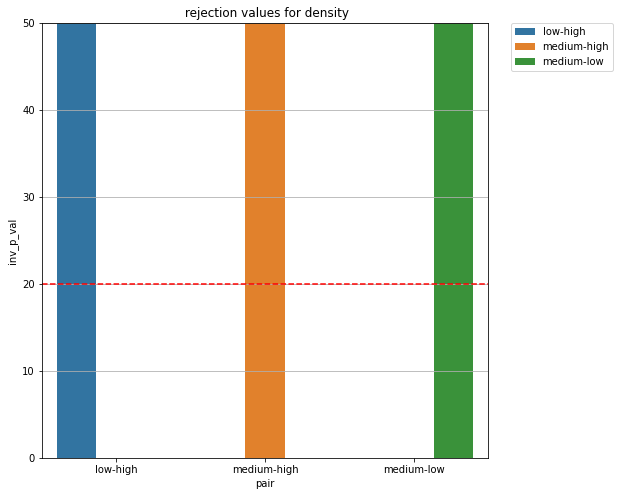

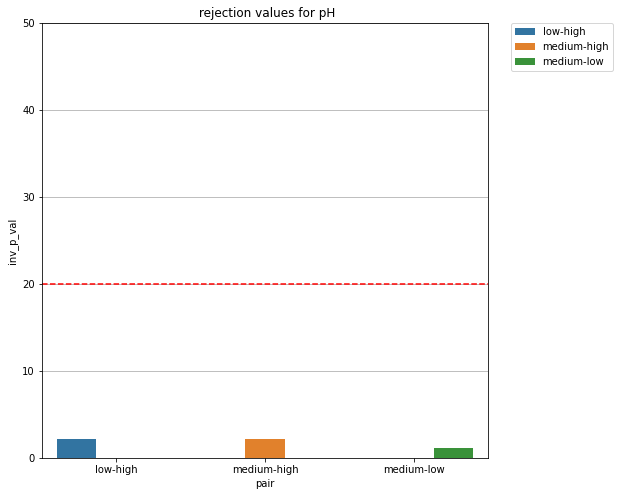

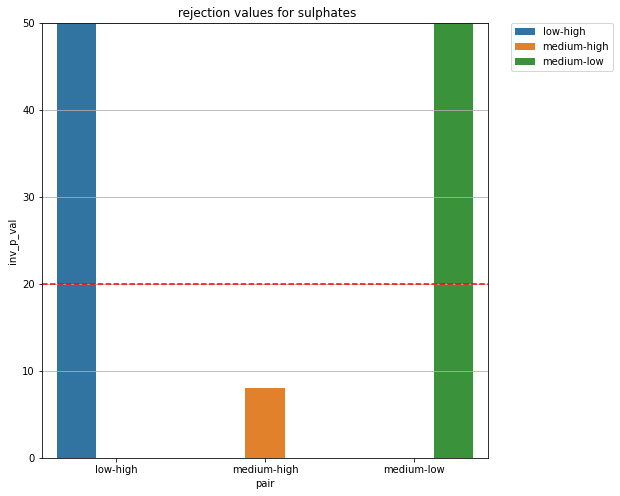

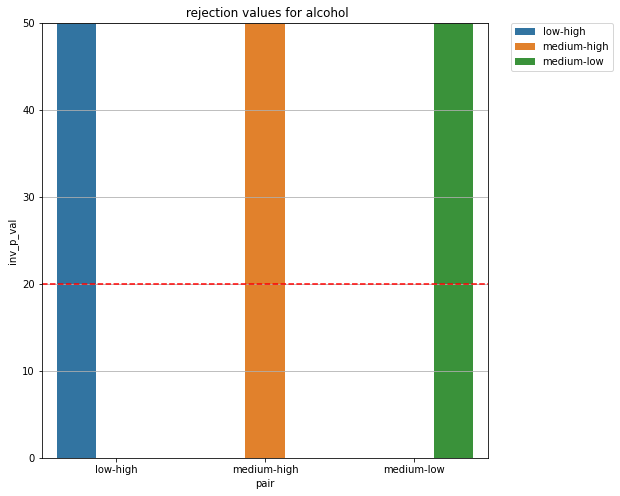

In [7]:
for ind,feature in enumerate(attributes):
    local_df= tukey_df[tukey_df['feature'] == feature]
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (8,8))
    fig.patch.set_facecolor('white')
    sns.barplot(data = local_df,x='pair',y='inv_p_val', hue='pair', ax = ax)
    ax.set_ylim(0,50)
    ax.axhline(y = 0.05**(-1), c = 'r', linestyle = '--')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    tit =f' rejection values for {feature}'
    ax.set_title(tit)
    ax.grid(b=True, which='both', axis='y')
# plt.savefig(f'plots/red/rejection value forquality labels by {feature}.png')

# Using boxplots to visualize the IQR 25%-75% of different features

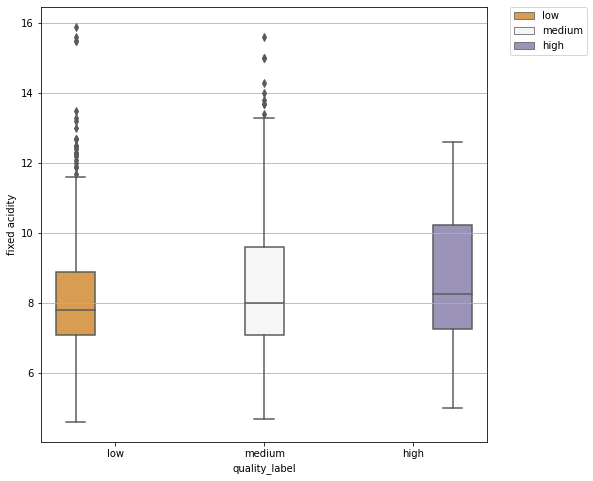

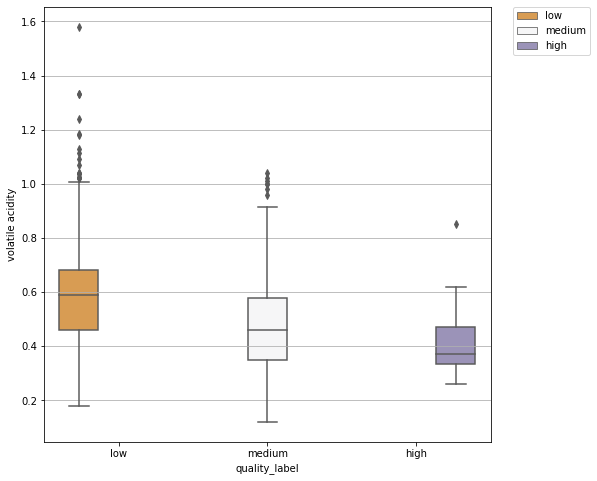

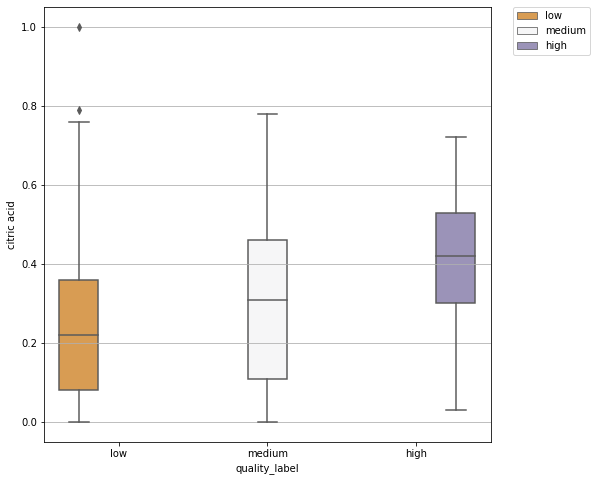

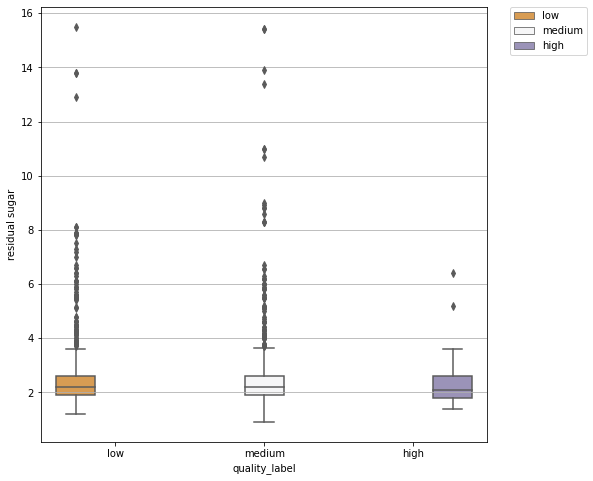

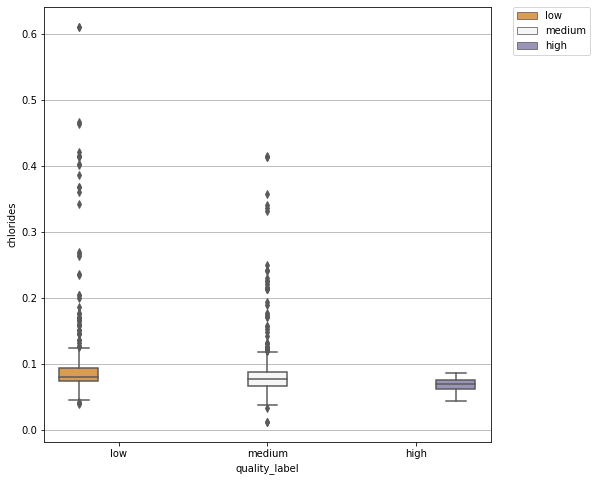

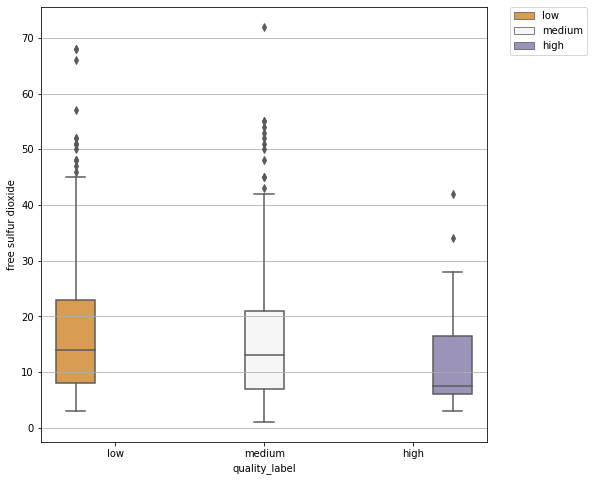

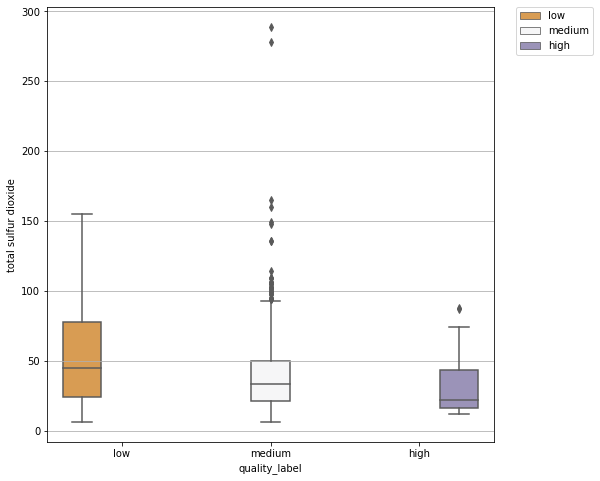

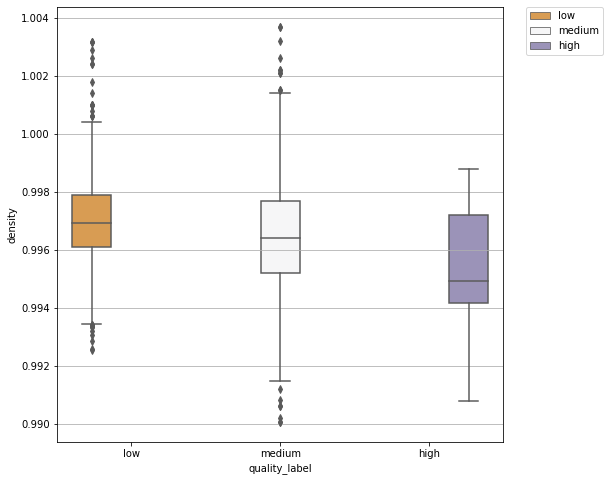

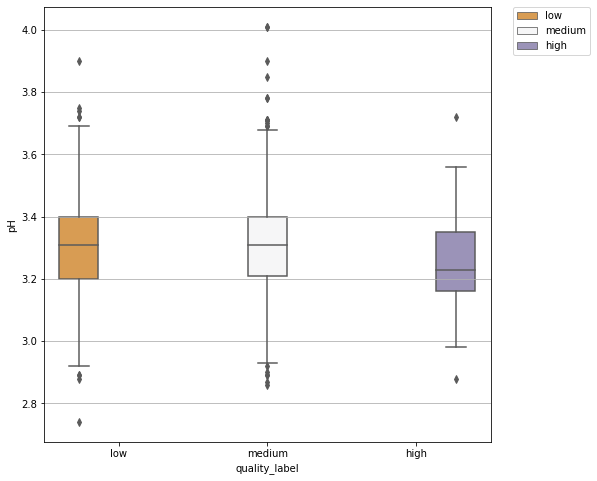

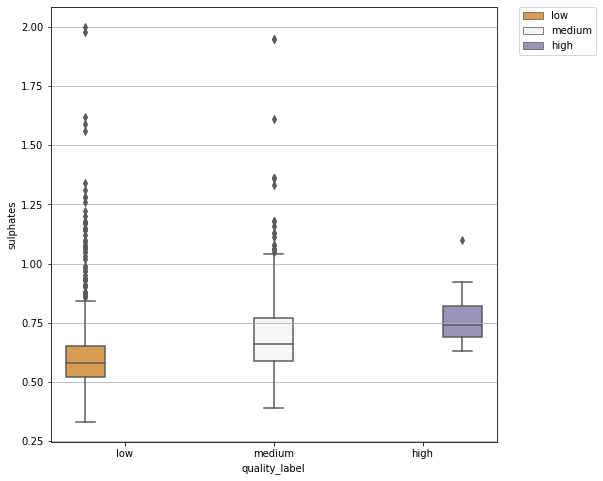

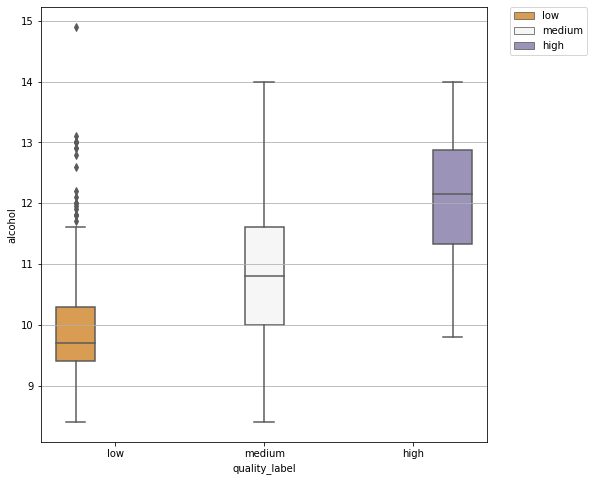

In [8]:
for ind,feature in enumerate(attributes):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (8,8))
    fig.patch.set_facecolor('white')
    sns.boxplot(data = df,x='quality_label',y=f'{feature}', hue='quality_label',palette = 'PuOr', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/red/{feature}_by_quality_label.png')

# using histograms to visualize distributions of datapoints in features

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


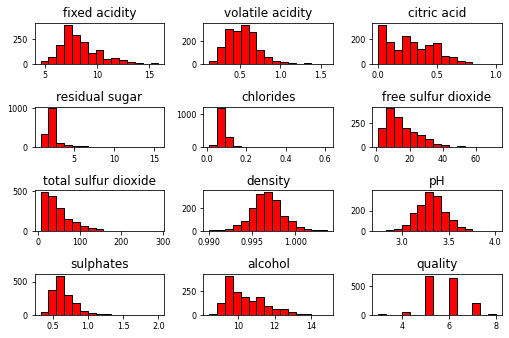

In [9]:
df.hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))

# EDA Summary:
* except for pH and residual sugars, all other features have statistically significant difference between the 3 quality wine_labels
* The following features have approximately normal distribution of values: fixed acidity, density, ph.
* the following feature are sqewed towards higher values: residual sugars, chlorides, free sulfur dioxide, total sulfur dioxide, sulphates, alcohol
* the distribution of citric acid values is tri-modal and sqewed to higher values.

# Selecting classification models:
* different models would be compared using different sampling methods and scaling methods, the goal is to select a method with low bias towards each quality label - a model in which the f1 scores for each model are the closest to the average f1 score.

In [10]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [11]:
label_quality = LabelEncoder()

In [12]:
df['quality_label']=label_quality.fit_transform(df.quality_label)

* create_models_comparisons is comparing the selcted models in a given sampler and scaler, and summarizing the classification reports from each model in a table to be visualized.

In [13]:
def create_model_report(model,X,y, pipeline = False, sampler = None, scaler = None):
    """
    assumes
        model is sklearn predictor
        model_name str representation of model
        X is training data
        y, target values
        pipeline bool
        sampler sampler object (SMOTE,under_sampler,etc...)
        scaler scikit scaler
    return
        list of values - ['precision_low', 'recall_low', 'f1-score_low', 'support_low','precision_medium','recall_medium', 'f1-score_medium', 'support_medium','precision_high', 'recall_high', 'f1-score_high', 'support_high','accuracy']
    """
    def reporting(model_name, report):
        """
        assumes
            report dict classification report
        returns
            list of values from classification report
        """
        l = [model_name]
        for key, item in report.items():
            if key == 'accuracy':
                l.append(round(item,3))
            else:
                for k,value in item.items():
                    l.append(round(value,3))
        return l
    model_name = model[0]
    model_obj = model[1]
    wine_labels = list(df.quality_label.unique())
    if pipeline:
        X_samp,y_samp = sampler.fit_resample(X,y)
        X_scaled = scaler.fit_transform(X_samp)
        X_train,X_test, y_train,y_test = train_test_split(X_scaled, y_samp, test_size = 0.2, random_state=42)
        model_obj.fit(X_train,y_train)
        report = classification_report(y_test, model_obj.predict(X_test), labels = wine_labels, output_dict = True)
        return reporting(model_name, report)
    else:
            
        X_train,X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
        model_obj.fit(X_train,y_train)
        report = classification_report(y_test, model_obj.predict(X_test), labels = wine_labels, output_dict = True)
        return reporting(model_name, report)

In [14]:
def create_models_comparison(scaler, models, model_names, sampler = None):
    """
    assumes:
        scaler a scikit learn scaler object
        models list of scikit-learn estimators
        model_names list of string corresponding to models
        sampler a sampler object default None
    returns:
        pandas DataFrame object
    """
    models_tup = []
    reports = []
    for i in range(len(models)):
        models_tup.append((model_names[i],models[i]))
    cols = ['model_name','precision_low', 'recall_low', 'f1-score_low', 'support_low','precision_medium','recall_medium', 'f1-score_medium', 'support_medium','precision_high', 'recall_high', 'f1-score_high', 'support_high','accuracy','mac_avg_precision','mac_avg_recall','mac_avg_f1-score','mac_avg_support','w_avg_precision','w_avg_recall','w_avg_f1-score','w_avg_support']
    if sampler:
        X=df.drop(['quality','quality_label'],axis =1,inplace = False).to_numpy()
        y=df['quality_label'].to_numpy()
        for model in models_tup:
            reports.append(create_model_report(model,X,y, pipeline = True, sampler=sampler, scaler=scaler))
    else:
        df_scaled = scaler.fit_transform(df)
        X=df_scaled[:,:11]
        y=df['quality_label'].to_numpy()
        for model in models_tup:
            reports.append(create_model_report(model,X,y))
    return pd.DataFrame(reports,columns = cols )
        
        

In [15]:
models = [RandomForestClassifier(),LogisticRegression(),LinearSVC(), SVC(),GaussianNB()]
models_names = ['RandomForestClassifier','LogisticRegression','LinearSVC', 'SVC','KNeighborsClassifier','GaussianNB']

# Comparing models with Standard scaler and no sampling

In [16]:
models_report_StnSc = create_models_comparison(StandardScaler(),models,models_names)
models_report_StnSc

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblin

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.766       0.766         0.766   
1      LogisticRegression          0.686       0.745         0.714   
2               LinearSVC          0.673       0.759         0.713   
3                     SVC          0.722       0.773         0.747   
4    KNeighborsClassifier          0.703       0.688         0.695   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          141             0.787          0.805            0.795   
1          141             0.754          0.724            0.739   
2          141             0.758          0.701            0.728   
3          141             0.781          0.759            0.770   
4          141             0.729          0.759            0.744   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             174             0.0          0.0            0.0             5   
1             174             0.0          0.0            0.0             5   
2             174             0.0          0.0            0.0             5   
3             174             0.0          0.0            0.0             5   
4             174             0.0          0.0            0.0             5   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.775              0.517           0.524             0.520   
1     0.722              0.480           0.490             0.484   
2     0.716              0.477           0.487             0.481   
3     0.753              0.501           0.511             0.505   
4     0.716              0.477           0.482             0.480   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              320            0.765         0.775           0.770   
1              320            0.713         0.722           0.717   
2              320            0.709         0.716           0.710   
3              320            0.743         0.753           0.747   
4              320            0.706         0.716           0.711   

   w_avg_support  
0            320  
1            320  
2            320  
3            320  
4            320

<ipython-input-17-0213797bdf3c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


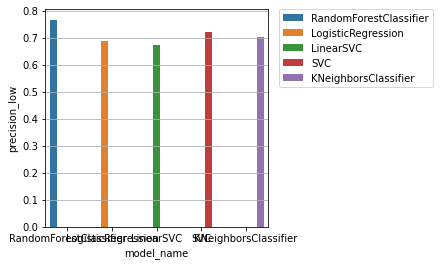

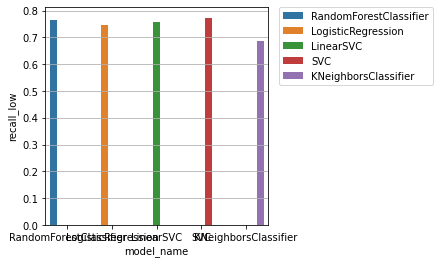

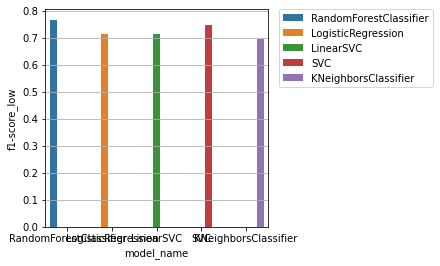

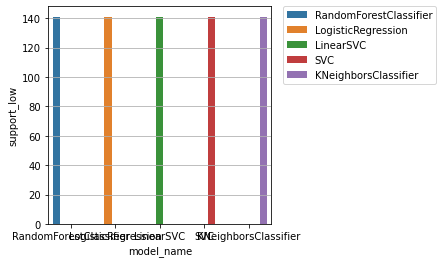

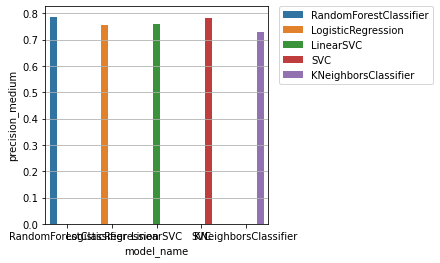

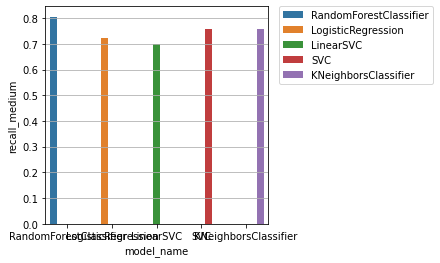

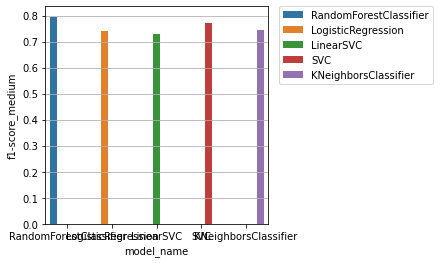

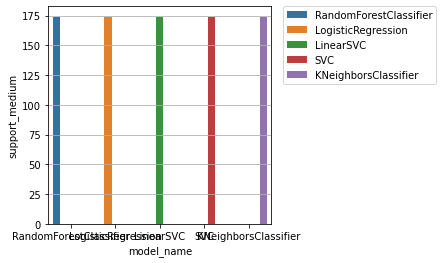

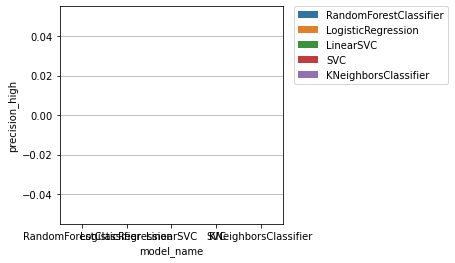

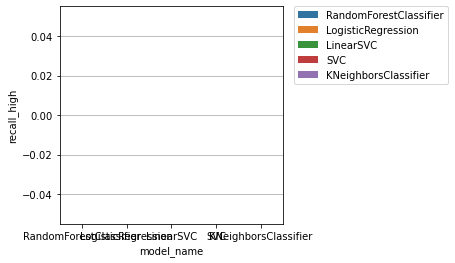

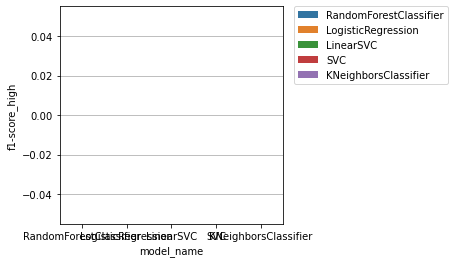

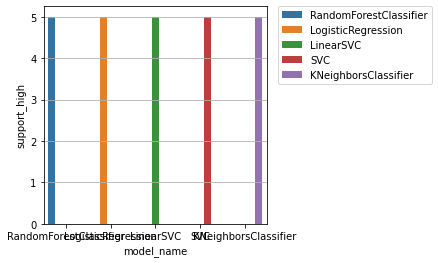

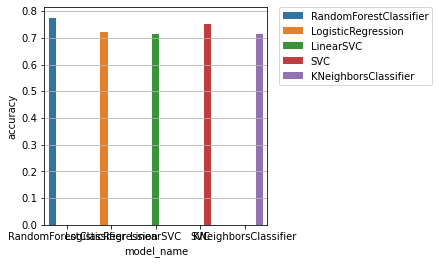

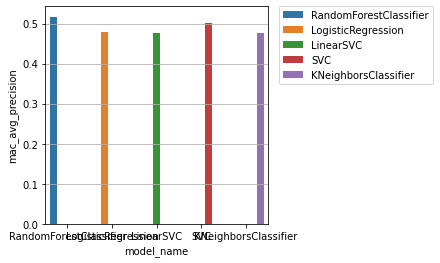

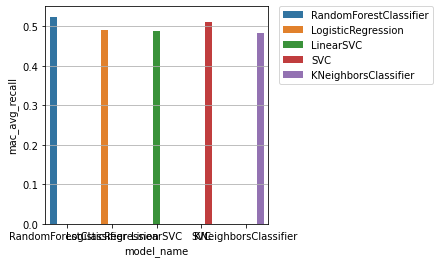

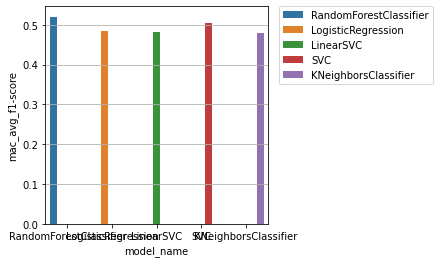

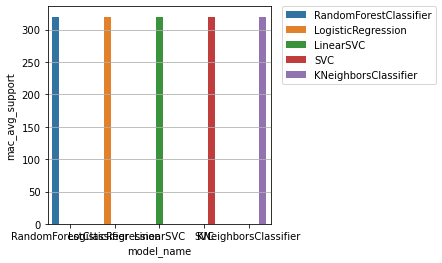

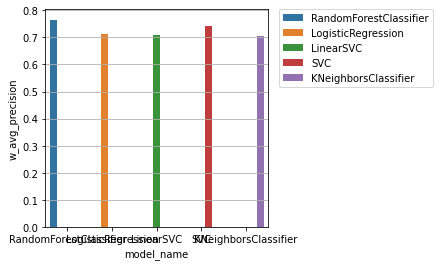

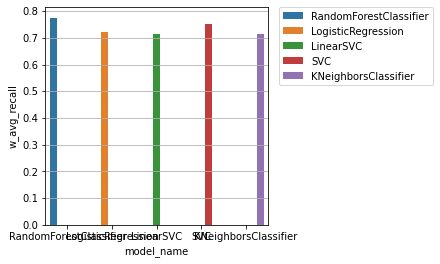

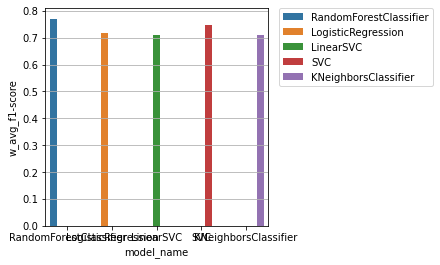

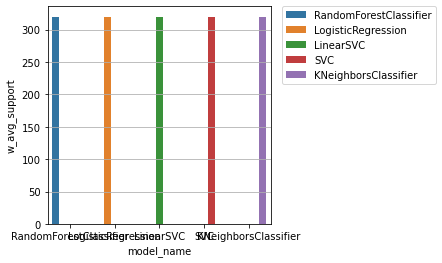

In [17]:
benchmarks = models_report_StnSc.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_StnSc,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models with random undersampling and MinMaxScaler

In [18]:
models_report_under = create_models_comparison(MinMaxScaler(),models,models_names, sampler = RandomUnderSampler(random_state = 42))
models_report_under

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMe

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.500         1.0         0.667   
1      LogisticRegression          0.500         1.0         0.667   
2               LinearSVC          0.500         1.0         0.667   
3                     SVC          0.500         1.0         0.667   
4    KNeighborsClassifier          0.333         0.5         0.400   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0            2               0.5           0.25            0.333   
1            2               0.0           0.00            0.000   
2            2               0.0           0.00            0.000   
3            2               0.0           0.00            0.000   
4            2               0.4           0.50            0.444   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0               4           0.800          0.8          0.800             5   
1               4           0.714          1.0          0.833             5   
2               4           0.714          1.0          0.833             5   
3               4           0.667          0.8          0.727             5   
4               4           1.000          0.6          0.750             5   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.636              0.600           0.683             0.600   
1     0.636              0.405           0.667             0.500   
2     0.636              0.405           0.667             0.500   
3     0.545              0.389           0.600             0.465   
4     0.545              0.578           0.533             0.531   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0               11            0.636         0.636           0.606   
1               11            0.416         0.636           0.500   
2               11            0.416         0.636           0.500   
3               11            0.394         0.545           0.452   
4               11            0.661         0.545           0.575   

   w_avg_support  
0             11  
1             11  
2             11  
3             11  
4             11

<ipython-input-19-6b82f6151818>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


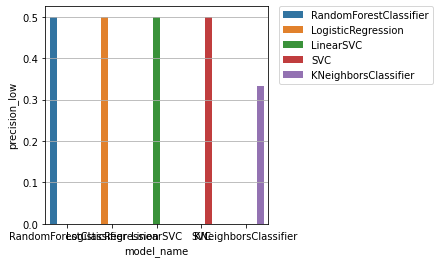

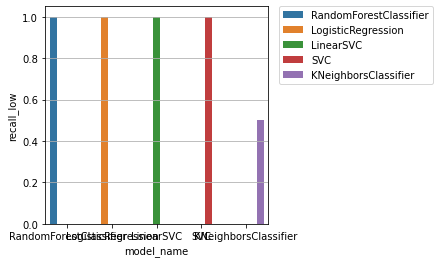

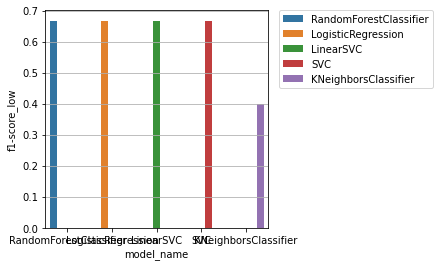

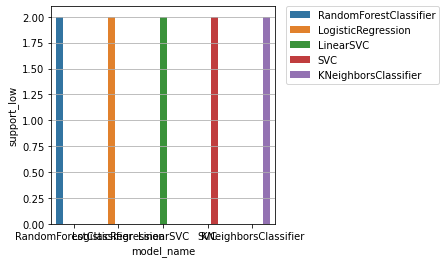

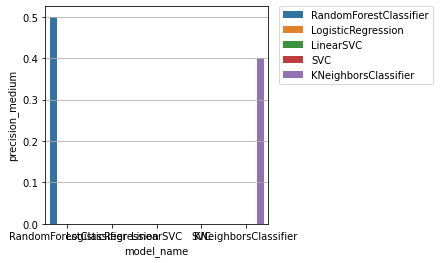

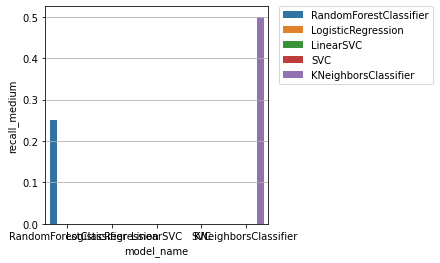

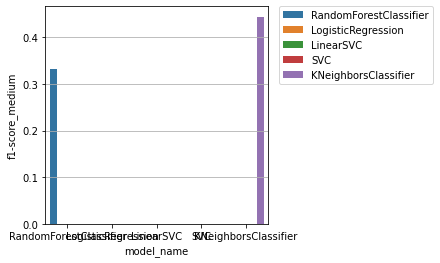

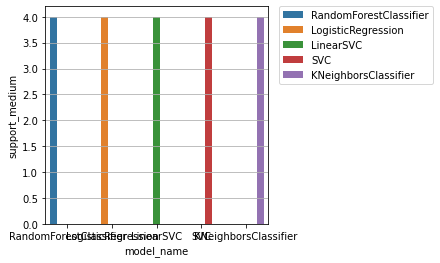

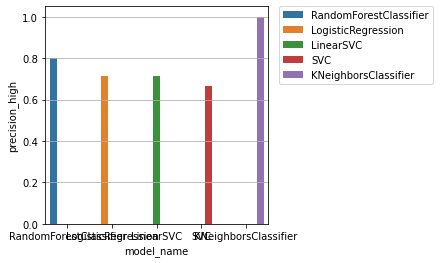

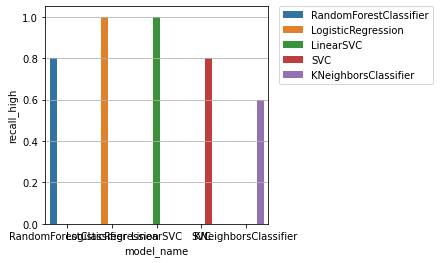

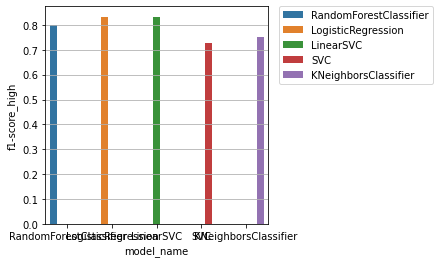

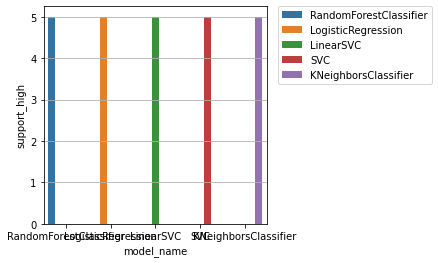

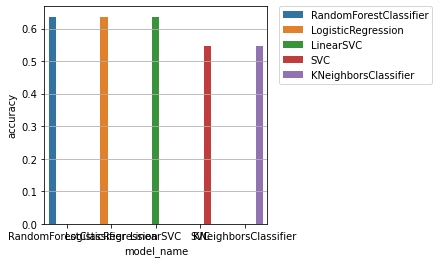

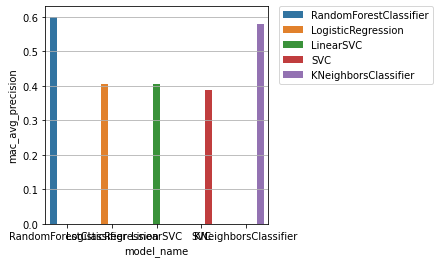

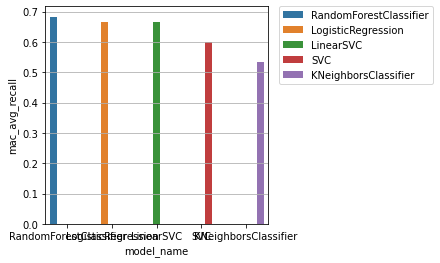

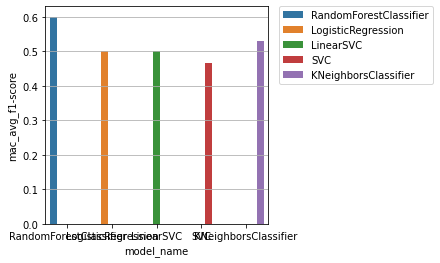

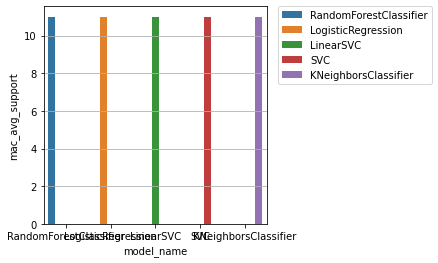

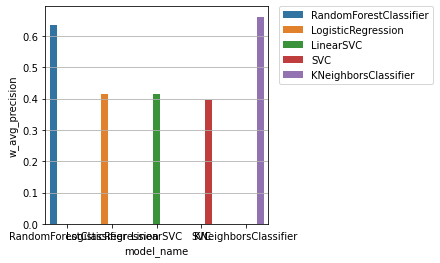

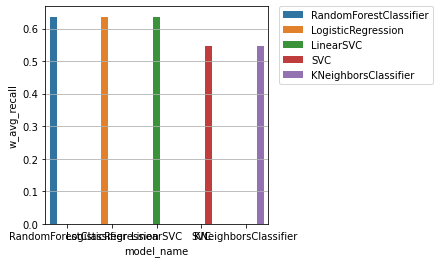

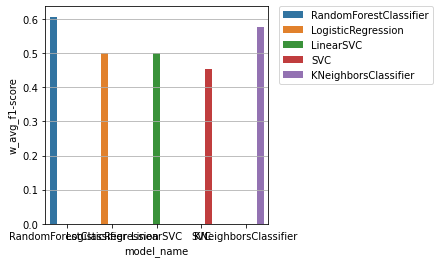

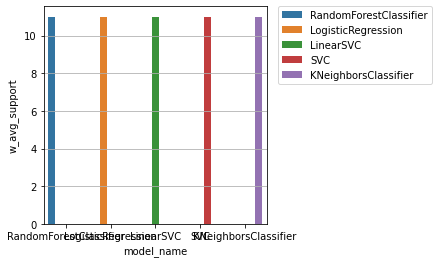

In [19]:
benchmarks = models_report_under.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_under,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models with random SMOTE and StandardScaler

In [20]:
models_report_SMOTE = create_models_comparison(StandardScaler(),models,models_names, sampler = SMOTE(random_state = 42))
models_report_SMOTE

/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.798       0.840         0.818   
1      LogisticRegression          0.753       0.811         0.781   
2               LinearSVC          0.701       0.846         0.767   
3                     SVC          0.774       0.811         0.792   
4    KNeighborsClassifier          0.706       0.751         0.728   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          169             0.803          0.735            0.768   
1          169             0.706          0.497            0.583   
2          169             0.671          0.316            0.430   
3          169             0.746          0.587            0.657   
4          169             0.488          0.400            0.440   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             155           0.973        0.994          0.983           179   
1             155           0.835        0.989          0.905           179   
2             155           0.783        0.989          0.874           179   
3             155           0.877        1.000          0.935           179   
4             155           0.770        0.844          0.805           179   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.863              0.858           0.857             0.857   
1     0.777              0.765           0.765             0.756   
2     0.734              0.718           0.717             0.690   
3     0.809              0.799           0.799             0.795   
4     0.676              0.655           0.665             0.658   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              503            0.862         0.863           0.862   
1              503            0.768         0.777           0.764   
2              503            0.721         0.734           0.701   
3              503            0.802         0.809           0.801   
4              503            0.662         0.676           0.667   

   w_avg_support  
0            503  
1            503  
2            503  
3            503  
4            503

<ipython-input-21-19da467d0bf2>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


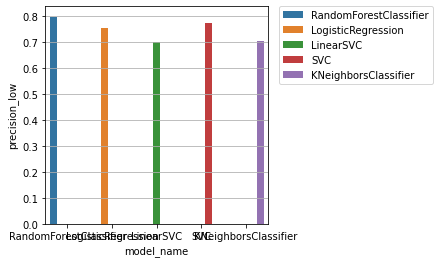

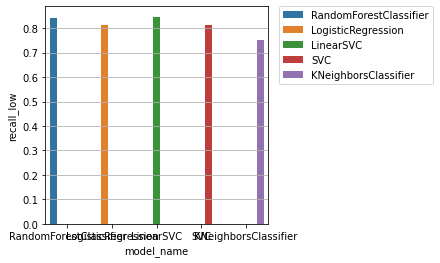

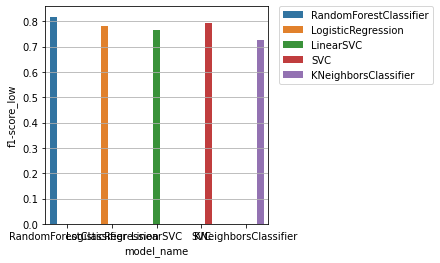

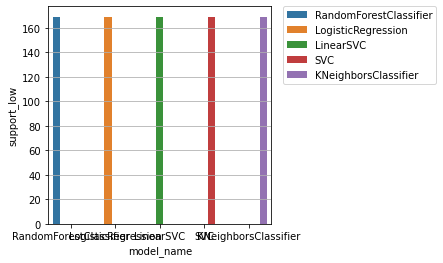

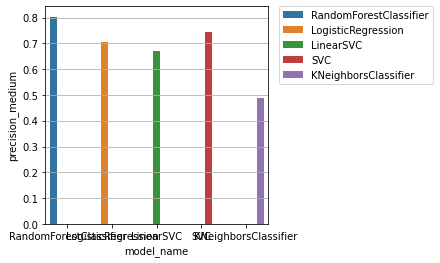

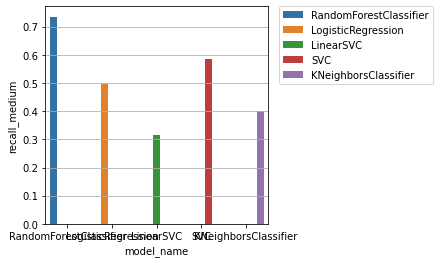

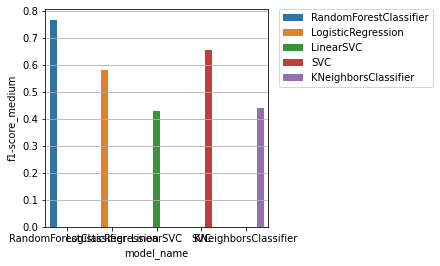

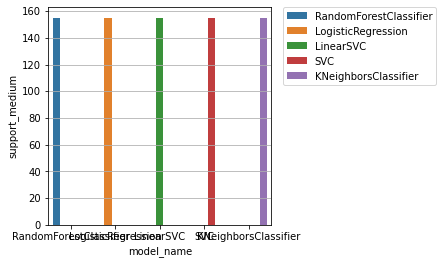

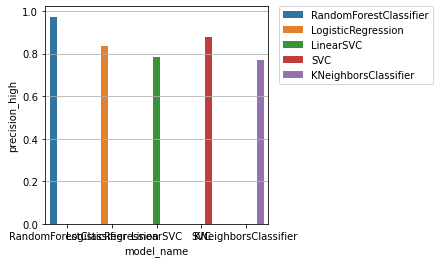

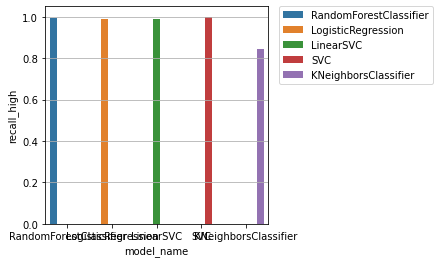

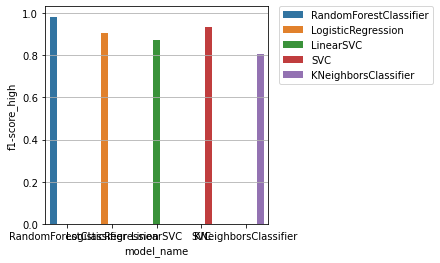

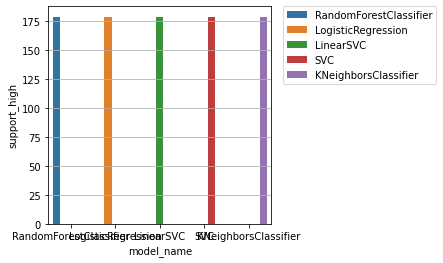

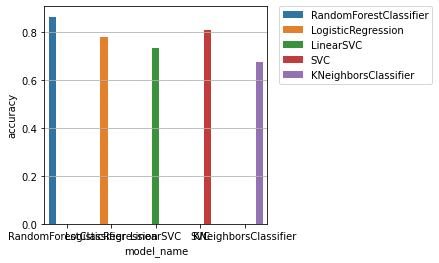

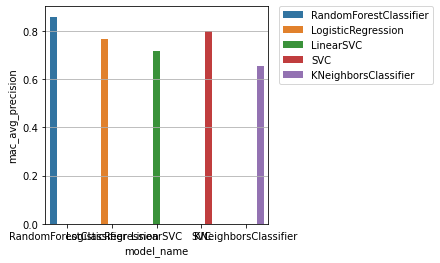

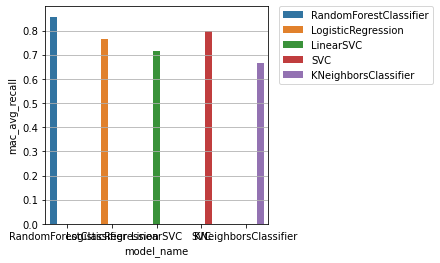

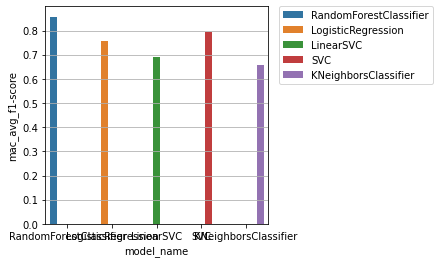

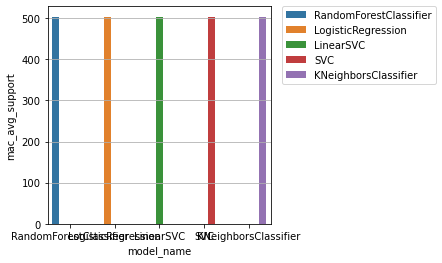

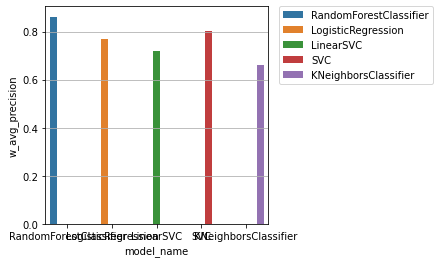

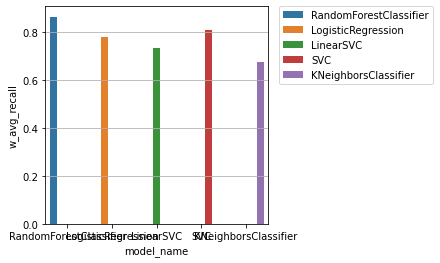

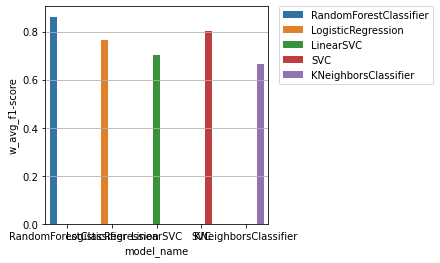

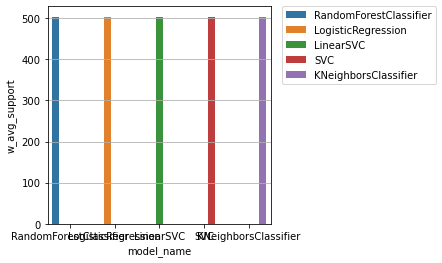

In [21]:

benchmarks = models_report_SMOTE.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_SMOTE,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models using Robust scaler without resampling

In [22]:
from sklearn.preprocessing import RobustScaler
models_report_robscale = create_models_comparison(RobustScaler(),models,models_names)
models_report_robscale

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblin

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.750       0.766         0.758   
1      LogisticRegression          0.684       0.752         0.716   
2               LinearSVC          0.671       0.752         0.709   
3                     SVC          0.692       0.766         0.727   
4    KNeighborsClassifier          0.703       0.688         0.695   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          141             0.783          0.787            0.785   
1          141             0.758          0.718            0.737   
2          141             0.753          0.701            0.726   
3          141             0.768          0.724            0.746   
4          141             0.729          0.759            0.744   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             174             0.0          0.0            0.0             5   
1             174             0.0          0.0            0.0             5   
2             174             0.0          0.0            0.0             5   
3             174             0.0          0.0            0.0             5   
4             174             0.0          0.0            0.0             5   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.766              0.511           0.518             0.514   
1     0.722              0.480           0.490             0.485   
2     0.713              0.475           0.484             0.478   
3     0.731              0.487           0.497             0.491   
4     0.716              0.477           0.482             0.480   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              320            0.756         0.766           0.761   
1              320            0.713         0.722           0.717   
2              320            0.705         0.713           0.707   
3              320            0.723         0.731           0.726   
4              320            0.706         0.716           0.711   

   w_avg_support  
0            320  
1            320  
2            320  
3            320  
4            320

<ipython-input-23-4eec8cad54ba>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


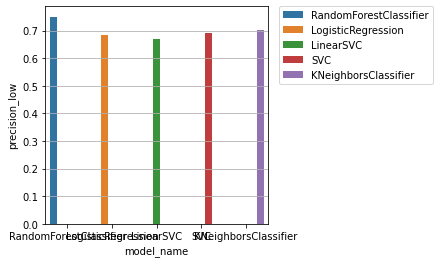

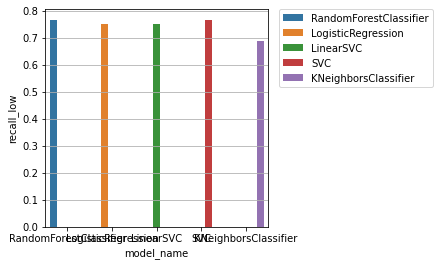

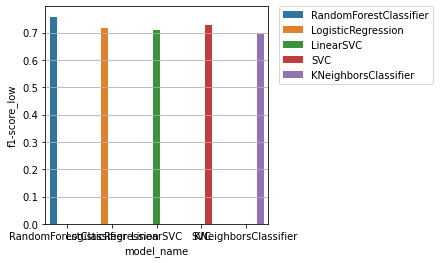

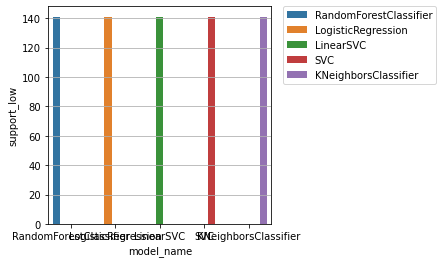

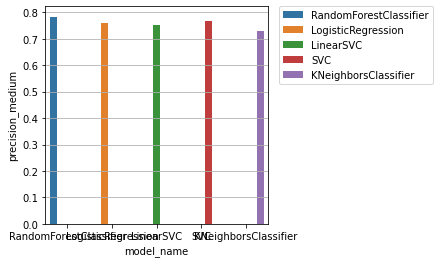

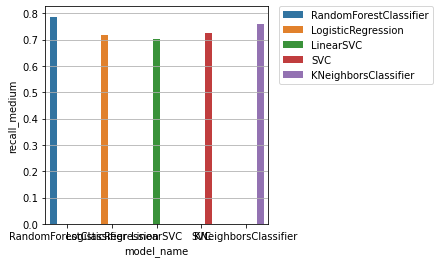

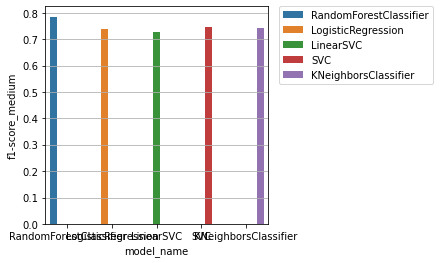

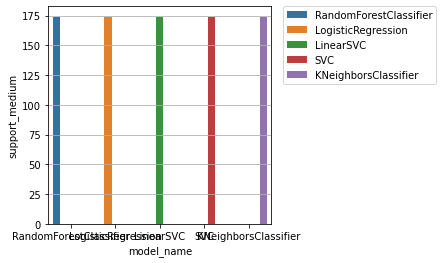

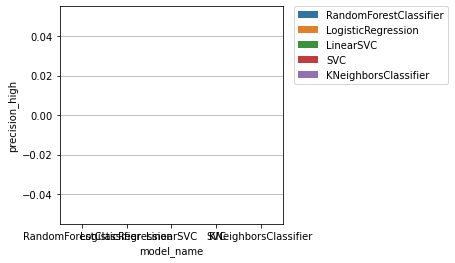

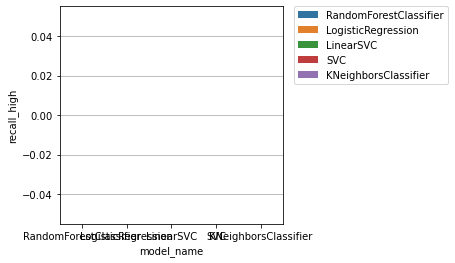

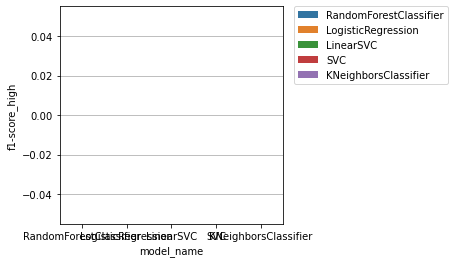

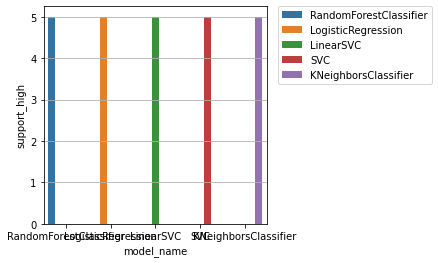

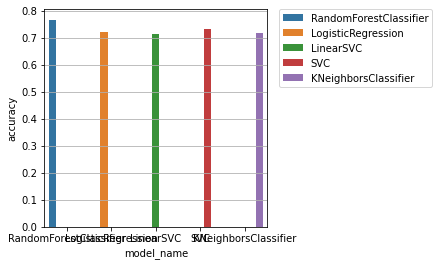

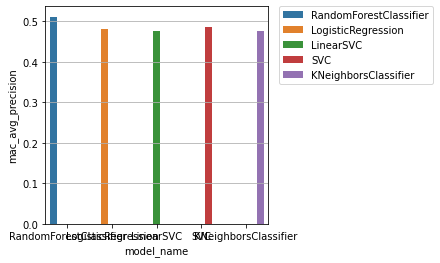

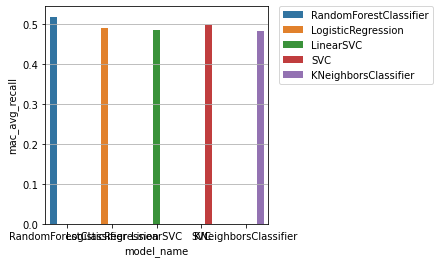

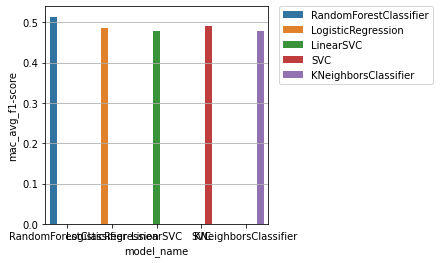

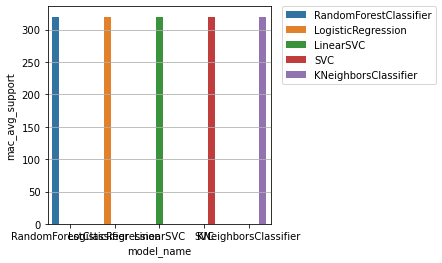

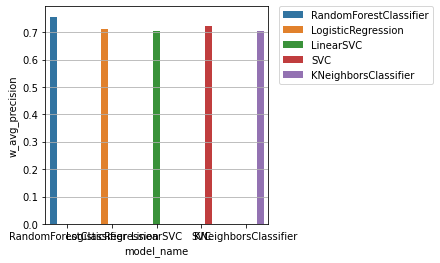

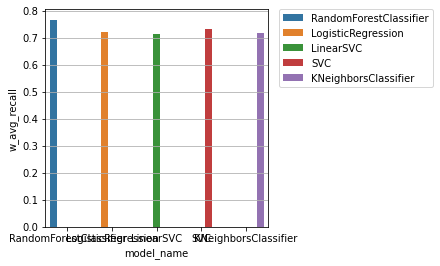

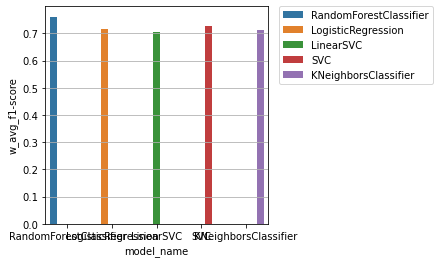

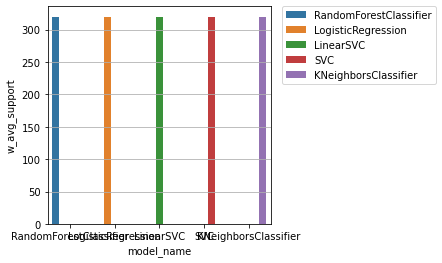

In [23]:

benchmarks = models_report_robscale.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_robscale,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models using robust scaler with SMOTE

In [24]:
models_report_robSMOTE = create_models_comparison(RobustScaler(),models,models_names, sampler = SMOTE(random_state=42))
models_report_robSMOTE


/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.799       0.846         0.822   
1      LogisticRegression          0.755       0.822         0.788   
2               LinearSVC          0.698       0.846         0.765   
3                     SVC          0.765       0.828         0.795   
4    KNeighborsClassifier          0.706       0.751         0.728   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          169             0.807          0.729            0.766   
1          169             0.714          0.484            0.577   
2          169             0.667          0.310            0.423   
3          169             0.745          0.529            0.619   
4          169             0.488          0.400            0.440   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             155           0.967        0.994          0.981           179   
1             155           0.827        0.989          0.901           179   
2             155           0.783        0.989          0.874           179   
3             155           0.852        1.000          0.920           179   
4             155           0.770        0.844          0.805           179   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.863              0.858           0.857             0.856   
1     0.777              0.766           0.765             0.755   
2     0.732              0.716           0.715             0.687   
3     0.797              0.788           0.786             0.778   
4     0.676              0.655           0.665             0.658   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              503            0.861         0.863           0.861   
1              503            0.768         0.777           0.763   
2              503            0.719         0.732           0.698   
3              503            0.790         0.797           0.785   
4              503            0.662         0.676           0.667   

   w_avg_support  
0            503  
1            503  
2            503  
3            503  
4            503

<ipython-input-25-dff7b36f945f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


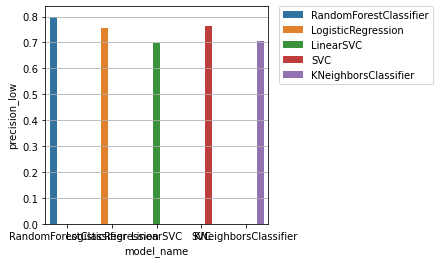

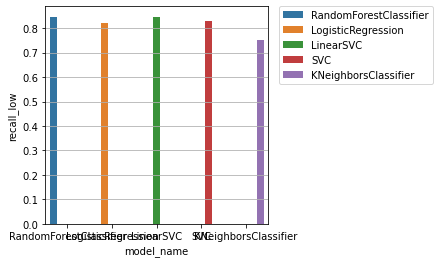

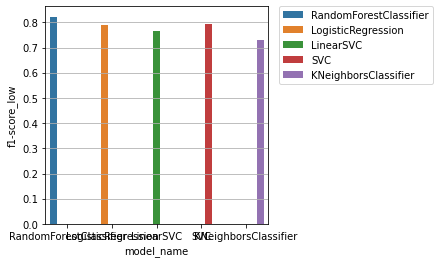

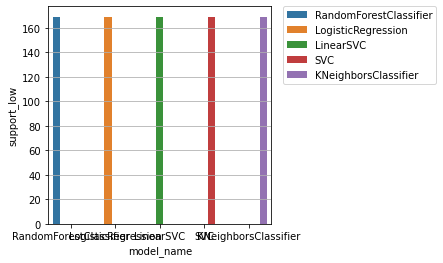

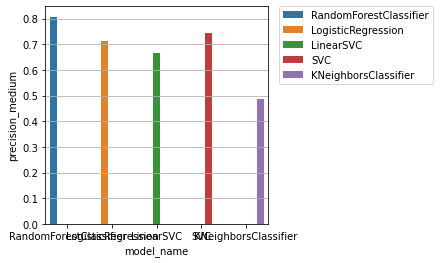

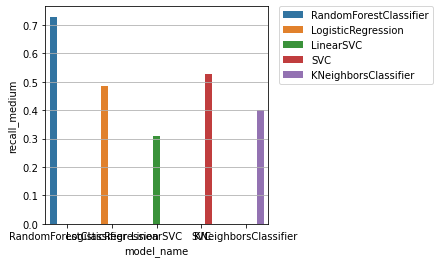

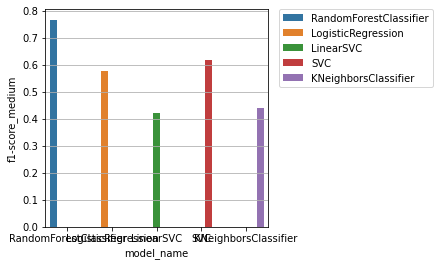

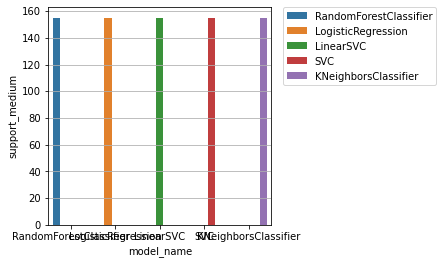

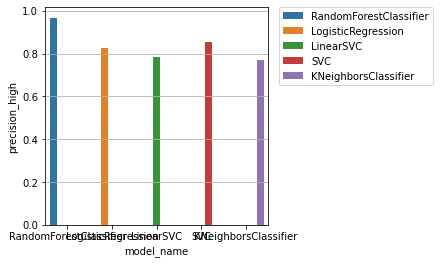

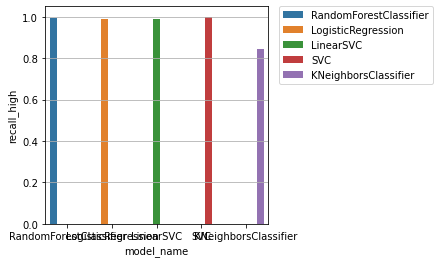

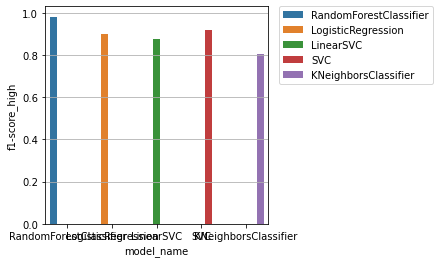

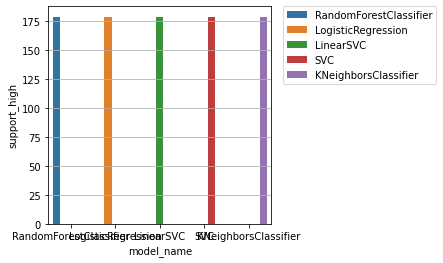

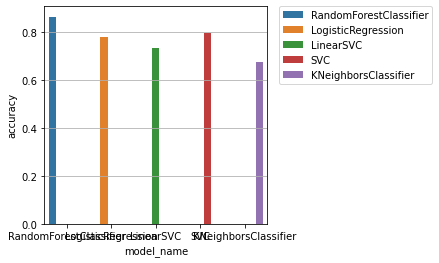

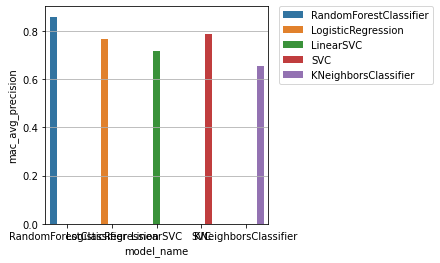

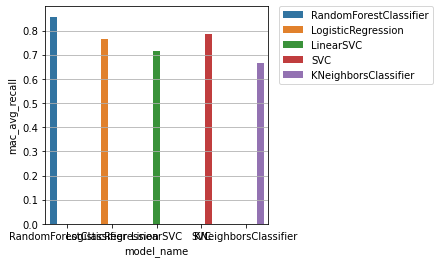

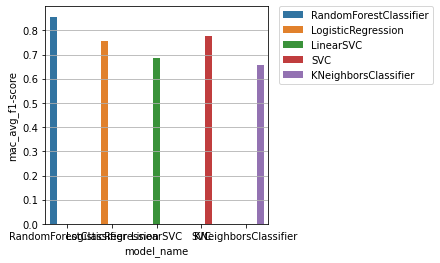

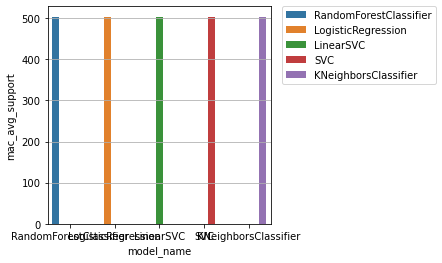

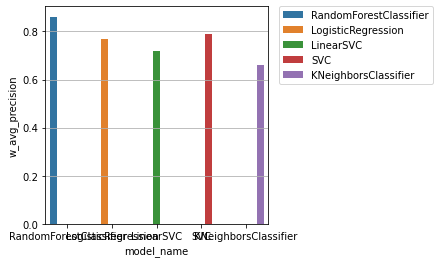

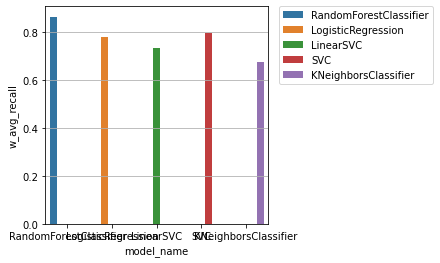

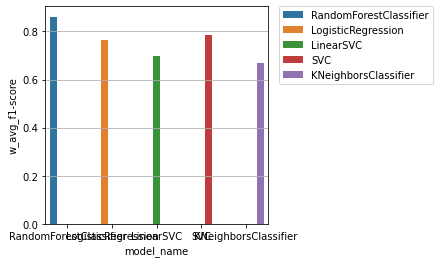

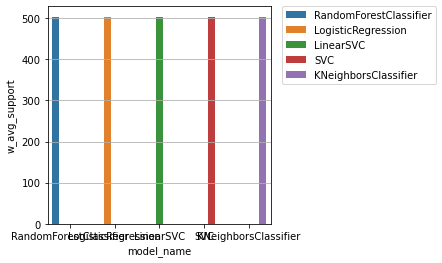

In [25]:
benchmarks = models_report_robSMOTE.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_robSMOTE,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# summary from models comparison:
* both standard scaling and robust (median-IQR) scaling are biased against quality_label high due to small number of data points (18 high compared to 744 low and 834 medium)
* Undersampling and MinMax scaler are biased in favor of label quality high, perhaps due to immense data loss (11 data points in support in minmax in comparison to 320 data points in suport in standard scaling without resampling )
* random forest classifier model achieved highet accuracy and balanced f1 and precision across labels both with standardscaler and robust scaler
### next step: comparing the results of random forest classifier with SMOTE scaling of standard scaler against robust scaler:

In [26]:
rfc_ss_df = models_report_SMOTE[models_report_SMOTE.model_name == 'RandomForestClassifier']
rfc_rs_df = models_report_robSMOTE[models_report_robSMOTE.model_name == 'RandomForestClassifier']
rfc_ss_df['scaler'] = 'StandardScaler'
rfc_rs_df['scaler'] = 'RobustScaler'
rfc_df = rfc_ss_df.append(rfc_rs_df)
rfc_df.drop('model_name',axis = 1, inplace = True)

<ipython-input-26-0325fff3a05a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfc_ss_df['scaler'] = 'StandardScaler'
<ipython-input-26-0325fff3a05a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfc_rs_df['scaler'] = 'RobustScaler'


In [27]:
ss_precision = rfc_ss_df.drop(['model_name', 'recall_low', 'f1-score_low',
       'support_low', 'recall_medium', 'f1-score_medium',
       'support_medium', 'recall_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler'],axis = 1,inplace = False).to_numpy()
ss_recall = rfc_ss_df.drop(['model_name', 'precision_low', 'f1-score_low',
       'support_low', 'precision_medium', 'f1-score_medium',
       'support_medium', 'precision_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler'],axis = 1,inplace = False).to_numpy()
ss_f1 = rfc_ss_df.drop(['model_name', 'precision_low', 'recall_low',
       'support_low', 'precision_medium', 'recall_medium',
       'support_medium', 'precision_high', 'recall_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler'],axis = 1,inplace = False).to_numpy()
rs_precision = rfc_rs_df.drop(['model_name', 'recall_low', 'f1-score_low',
       'support_low', 'recall_medium', 'f1-score_medium',
       'support_medium', 'recall_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler'],axis = 1,inplace = False).to_numpy()
rs_recall = rfc_rs_df.drop(['model_name', 'precision_low', 'f1-score_low',
       'support_low', 'precision_medium', 'f1-score_medium',
       'support_medium', 'precision_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler'],axis = 1,inplace = False).to_numpy()
rs_f1 = rfc_rs_df.drop(['model_name', 'precision_low', 'recall_low',
       'support_low', 'precision_medium', 'recall_medium',
       'support_medium', 'precision_high', 'recall_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler'],axis = 1,inplace = False).to_numpy()

In [28]:
data = {'Scaler':['StandardScaler','RobustScaler'],
        'std_Precision':[np.std(ss_precision),np.std(rs_precision)],
        'std_Recall':[np.std(ss_recall),np.std(rs_recall)],
        'std_f1-score':[np.std(ss_f1),np.std(rs_f1)]}
std_df = pd.DataFrame.from_dict(data)
std_df

Scaler  std_Precision  std_Recall  std_f1-score
0  StandardScaler       0.081343    0.106365      0.091863
1    RobustScaler       0.077379    0.108432      0.091069

* Standard sclaer has only slightly higher (~0.001) deviation in precision, but lower deviation with recall and f1.
* Therefore, the selected model for prediction is Random Forest classifier, with SMOTE sampling and standard scaler
* next, The model is to be optimized with the aid of GridsearchCV

In [29]:
X=df.drop(['quality','quality_label'],axis =1,inplace = False).to_numpy()
y=df['quality_label'].to_numpy()
smote = SMOTE()
stan_scaler = StandardScaler()
X_resamp, y_resamp = smote.fit_resample(X,y)
X_scaled = stan_scaler.fit_transform(X_resamp)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_resamp,test_size = 0.2, random_state = 42)

## Using cohen_kappa to select the optimal parameters for the Random Forest Classifier

In [30]:
from sklearn.metrics import cohen_kappa_score, make_scorer
cohen_kappa = make_scorer(cohen_kappa_score)
params_dict={'n_estimators':[50,100,500,1000],'criterion':['gini','entropy'],'class_weight':['balanced','balanced_subsample'],'random_state':[None,42],'max_features':['auto','sqrt','log2']}
clf_rf2=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),param_grid=params_dict,scoring = cohen_kappa,cv=10)
clf_rf2.fit(X_train,y_train)
print(clf_rf2.best_params_,clf_rf2.best_score_)

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42} 0.8132875282766541


In [35]:
import pickle
pickle.dump(red_rf2,open('red_rf.dat','wb'))

              precision    recall  f1-score   support

           1       0.81      0.84      0.82       169
           2       0.80      0.75      0.77       155
           0       0.97      0.99      0.98       179

    accuracy                           0.86       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.86      0.86      0.86       503



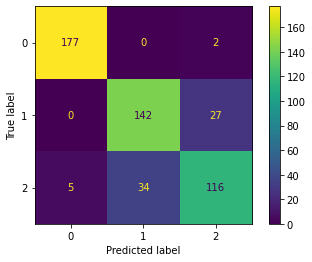

In [31]:
red_rf2 = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_features = 'auto', n_estimators =500)
red_rf2.fit(X_train, y_train)
print(classification_report(y_test, red_rf2.predict(X_test),labels = df.quality_label.unique()))
plot_confusion_matrix(red_rf2,X_test, y_test)
# plt.savefig('plots/red/confusion_matrix-coheb.png')

## Comparing the results of the classifier to a dummy classifier

              precision    recall  f1-score   support

           1       0.31      0.28      0.30       169
           2       0.32      0.36      0.34       155
           0       0.36      0.35      0.35       179

    accuracy                           0.33       503
   macro avg       0.33      0.33      0.33       503
weighted avg       0.33      0.33      0.33       503



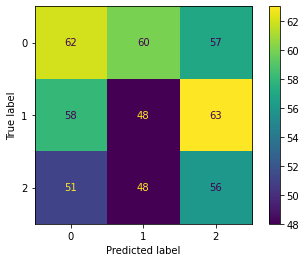

In [32]:
from sklearn.dummy import DummyClassifier

dumc = DummyClassifier(strategy = 'stratified', random_state=42)
dumc.fit(X_train, y_train)
print(classification_report(y_test,dumc.predict(X_test), labels = df.quality_label.unique()))
plot_confusion_matrix(dumc,X_test, y_test)
# plt.savefig('plots/red/dummy_confusion_matrix.png')